# Domain Champion
#### *Using GitHub's REST API

### This pattern aims to analyze which developer makes the most contributions for their respective project. We also analyze the proportion of commits they make to their project space as well.

#### Creating a Dataframe of Top Developers

We can start off by importing the packages we need and setting up our authentication parameters.

In [35]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

username = 'aacosta13'
token = '4a989428429d3c455513d1526c2662a8e77e2974'    


Next, we will want to make a dictionary set of the projects we want to analyze. This helps later with our data manipulation. We can also go ahead and set up our "data" dictionary, which will help frame a table of the data we collect.


In [36]:
project_dict = {
    'Moose': 'idaholab/moose',
    'Spack': 'spack/spack',
    'yt': 'yt-project/yt',
    'petsc': 'petsc/petsc',
    'E3SM': 'E3SM-Project/E3SM',
    'lammps': 'lammps/lammps',
    'gromacs': 'gromacs/gromacs',
    'OSGConnect': 'OSGConnect/TOREVIEW-tutorial-namd',
    'QMCPACK': 'QMCPACK/qmcpack',
    'Nek5000': 'Nek5000/Nek5000',
    'nwchemgit': 'nwchemgit/nwchem',
    'lanl': 'lanl/LATTE',
    'CRL': 'gridaphobe/CRL',
    'enzo-project': 'enzo-project/enzo-dev'
}

data = {'Repository Name': [],
        'Top Contributor': [],
        'Number of Contributions': []}
        

We will now go through each project from our dictionary and request the JSON info for each repo from the API. Additionally, we can start building our data dictionary up as well to display our findings.

In [37]:
for project in project_dict:
    url = 'https://api.github.com/repos/%s/contributors' % project_dict[project]

    response = requests.get(url, auth=(username, token))
    json_response = response.json()

    # Following block for creating dataframe
    data['Repository Name'].append(project)
    data['Top Contributor'].append(json_response[0]['login'])
    data['Number of Contributions'].append(json_response[0]['contributions'])


Let's go ahead and place that data into a Pandas dataframe to see what we've found.

In [38]:
df = pd.DataFrame(data)
print(df)

   Repository Name Top Contributor  Number of Contributions
0            Moose        permcody                     6254
1            Spack        tgamblin                     2562
2               yt     matthewturk                     8560
3            petsc      BarrySmith                    20803
4             E3SM      jedwards4b                     3747
5           lammps        akohlmey                     7133
6          gromacs        mabraham                     1808
7       OSGConnect          dmbala                       31
8          QMCPACK          ye-luo                     4931
9          Nek5000          stgeke                      466
10       nwchemgit         edoapra                     5758
11            lanl          cnegre                      163
12             CRL      gridaphobe                      132
13    enzo-project     matthewturk                      558


#### Visualizing Top Developer's Proportion of Commits (Histogram)

Next, we'll want to try and visualize how these developers stand up against their peers for their projects. We can go ahead and make a list of the projects (only needed to more easily display the names on the bar chart).

We will also go ahead and introduce a new parameter for our data dictionary to keep track of the total number of contributions for the whole repo. And lastly, two new data structures to help calculate the commit proportions.


In [39]:
project_list = ['Moose', 'Spack', 'yt', 'petsc', 'E3SM', 'lammps', 'gromacs',
                'OSGConnect', 'QMCPACK', 'Nek5000', 'nwchemgit', 'lanl', 'CRL', 'enzo-project']

data['Contribution Total for Repo'] = []
commit_proportion = []
commit_proportion_dict = {}


For this step, we will want to go ahead and start gathering the total count of commits per project. We use a helper function here to separate our work; these totals also get appended to our data dictionary to help correlate which project the counts belong to.

The list of commit proportions also get placed into a list to help form our bar chart.

In [40]:
def count_repo_commit(project, uname, tk):
    url = 'https://api.github.com/repos/%s/contributors' % project

    response = requests.get(url, auth=(uname, tk))
    json_response = response.json()

    count = 0
    for item in json_response:
        count += int(item['contributions'])

    return count


for project in project_dict:
    url = 'https://api.github.com/repos/%s/contributors' % project_dict[project]
    commit_count = count_repo_commit(project_dict[project], username, token)

    response = requests.get(url, auth=(username, token))
    json_response = response.json()

    # Following block for creating dataframe
    data['Contribution Total for Repo'].append(commit_count)

    if commit_count != 0:
        commit_proportion.append(int(json_response[0]['contributions']) / commit_count)
        commit_proportion_dict[project] = commit_proportion[-1]


This is just a minor step; we basically perform the following block of code to sort the values to display them in a descending order for our histogram.

In [41]:
# Sorting values to make Bar Chart
sorted_project_list = []
commit_proportion.sort(reverse=True)
for value in commit_proportion:
    for current_project, proportion in commit_proportion_dict.items():
        if value == proportion:
            sorted_project_list.append(current_project)


Finally, let's go ahead and make our histogram to see what we have below.

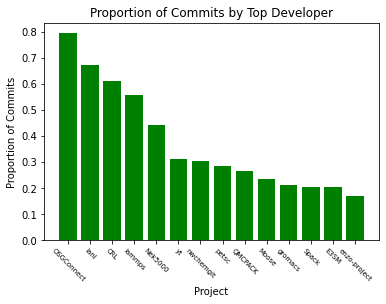

In [42]:
# Creating chart
x_pos = [i for i, _ in enumerate(sorted_project_list)]
plt.bar(x_pos, commit_proportion, color='green', align='center')
plt.xlabel("Project")
plt.ylabel("Proportion of Commits")
plt.title("Proportion of Commits by Top Developer")

plt.xticks(x_pos, sorted_project_list, size=7, rotation=-45)
plt.show()


One should be wary of interpreting this data, of course. As smaller projects may mislead the amount of work that a developer puts in compared to their peers. For example, OSGConnect's lead project developer may seem to be the only one doing work based off this chart, but further inspection reminds one that the project is led with 31 commits as the lead. Therefore, this project is likely to be small, so the proportions will be more exaggerated.


# In the Zone


### For this development pattern, we'll want to analyze what time of day it is that the developers for each project tend to make their contributions to the project.


#### Creating a heatmap visualization

Our goal for this pattern is to represent all the "time zones" that the projects' developers make their contributions by using a heatmap.

We'll start off by importing over the datetime package we'll need and establishing the the objects we will use to manipulate the time information.


In [43]:
import datetime

# Setting up time objects for organizing data
temp = datetime.datetime.now()
early_morning = temp.replace(hour=5, minute=0, second=0, microsecond=0).time()
work_day = temp.replace(hour=9, minute=0, second=0, microsecond=0).time()
after_work = temp.replace(hour=17, minute=0, second=0, microsecond=0).time()
late_night = temp.replace(hour=23, minute=0, second=0, microsecond=0).time()
# Following time period created to account for 0:00 (midnight)
after_late_night = temp.replace(hour=0, minute=0, second=0, microsecond=0).time()


This next section will be a bit lengthy, as it will be the main method used to cycle through the API's information to compile together the time blocks.

The general procedure involves creating a dictionary to section off our time blocks that will be used for creating the heatmap. We also go into the necessary JSON items to grab the time and add it to our data structures. 

Finally, we are also printing out whenever a project's timezones have been fetched to ensure the process is still continuing since the process takes a while.


In [47]:
# This list is a helper to build the heatmap
project_time_totals = []

print('Collecting commit time data now...')

def collect_commit_time(projectDict):
    for project in projectDict:
        # Dictionary used to keep track of commit times
        commit_time = {
            'Early Morning (5am-9am)': 0,
            'Work Day (9am-5pm)': 0,
            'After Work (5pm-11pm)': 0,
            'Late Night (11pm-5am)': 0
        }

        commit_url = 'https://api.github.com/repos/%s/commits?&per_page=100' % projectDict[project]
        commit_response = requests.get(commit_url, auth=(username, token))
        commit_json_response = commit_response.json()

        item_count = 0
        page_no = 1
        max_page = False
        # Parse through JSON response of API for commits list
        while not max_page:
            for item in commit_json_response:
                # Grab time for commit and place it appropriately in the commit_time dict
                date = item['commit']['committer']['date']
                time = datetime.datetime.strptime(date[11:-1], '%H:%M:%S').time()

                if work_day > time >= early_morning:
                    commit_time['Early Morning (5am-9am)'] += 1
                if after_work > time >= work_day:
                    commit_time['Work Day (9am-5pm)'] += 1
                if late_night > time >= after_work:
                    commit_time['After Work (5pm-11pm)'] += 1
                if early_morning > time >= after_late_night or time >= late_night:
                    commit_time['Late Night (11pm-5am)'] += 1

                item_count += 1

            if item_count == 100:
                page_no += 1
                commit_url += '&page=%s' % str(page_no)
                commit_response = requests.get(commit_url, auth=(username, token))
                commit_json_response = commit_response.json()
                item_count = 0

            else:
                max_page = True

        project_time_totals.append(list(commit_time.values()))
        print('%s commit times have been collected.' % project)

collect_commit_time(project_dict)


Moose commit times have been collected.
Spack commit times have been collected.
yt commit times have been collected.
petsc commit times have been collected.
E3SM commit times have been collected.
lammps commit times have been collected.
gromacs commit times have been collected.
OSGConnect commit times have been collected.
QMCPACK commit times have been collected.
Nek5000 commit times have been collected.
nwchemgit commit times have been collected.
lanl commit times have been collected.
CRL commit times have been collected.
enzo-project commit times have been collected.


Now, we can finally plot out our heatmap.

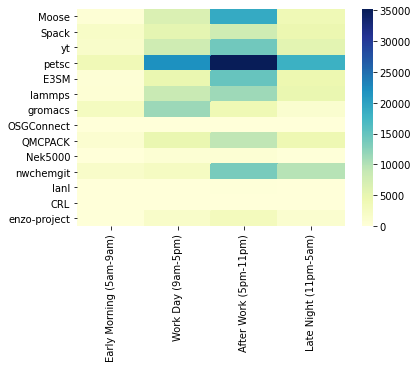

In [48]:
import seaborn as sns

# Construct dataframe for heatmap and plot
df = pd.DataFrame(data=project_time_totals, index=list(project_dict.keys()), columns=list(commit_time.keys()))
ax = sns.heatmap(df, cmap="YlGnBu")
plt.show()

As can be seen, our heatmap shows that our projects mainly seem to converge into the "After Work" time block of 5pm-11pm. This is an interesting outcome, however it is likely believable as it is likely that the developers for these projects must work on the projects after their "day job" requirements are finished for the day.


#### Analyzing each developer's commit times against their project's average time.


For this section, we will aim to analyze every developer (for each project) and the frequency of their commits.

The general process for this will be to collect the time data for each individual project. We then will use the information from that data set such as the average time block for the project to visualize when the developers are making their commits on average.

In [68]:
project_time_totals = []
projectChoiceDict = {}
authorDict = {}

projectChoice = input("Enter the name of the project to analyze: ")
projectChoiceDict[projectChoice] = project_dict[projectChoice]

commit_url = 'https://api.github.com/repos/%s/commits?&per_page=100' % projectChoiceDict[projectChoice]
commit_response = requests.get(commit_url, auth=(username, token))
commit_json_response = commit_response.json()

item_count = 0
page_no = 1
max_page = False
while not max_page:
    for item in commit_json_response:
        author = item['commit']['author']['name']

        if author not in authorDict:
            authorDict[author] = []

        date = item['commit']['committer']['date']
        time = datetime.datetime.strptime(date[11:-1], '%H:%M:%S').time()
        authorDict[author].append(time)

        item_count += 1

    if item_count == 100:
        page_no += 1
        commit_url += '&page=%s' % str(page_no)
        commit_response = requests.get(commit_url, auth=(username, token))
        commit_json_response = commit_response.json()
        item_count = 0

    else:
        max_page = True

print(authorDict)


Enter the name of the project to analyze: Moose
{'MOOSE Build': [datetime.time(5, 51, 26), datetime.time(17, 50, 4), datetime.time(18, 19, 3), datetime.time(4, 8, 25), datetime.time(21, 36, 59), datetime.time(1, 3, 38), datetime.time(0, 31, 45), datetime.time(2, 47, 3), datetime.time(1, 42, 39), datetime.time(0, 12, 57), datetime.time(6, 58, 35), datetime.time(4, 41, 24), datetime.time(1, 25, 41), datetime.time(20, 31, 43), datetime.time(20, 13, 26), datetime.time(4, 11, 35), datetime.time(3, 14, 16), datetime.time(22, 47, 24), datetime.time(1, 40, 5), datetime.time(1, 26, 38), datetime.time(1, 12, 11), datetime.time(23, 44, 16), datetime.time(19, 9, 31), datetime.time(18, 42, 46), datetime.time(18, 8, 20), datetime.time(16, 5, 49), datetime.time(5, 41, 26), datetime.time(20, 1, 14), datetime.time(2, 59, 49), datetime.time(20, 39, 12), datetime.time(18, 23, 57), datetime.time(0, 49, 17), datetime.time(20, 40, 26), datetime.time(1, 37, 58), datetime.time(0, 42, 34), datetime.time(6, 52,